#**RECOMMENDING QUALITY PRODUCTS BY EXPLOITING USER WRITTEN REVIEWS**








**PROBLEM STATEMENT**

Until recent years, there are no recommendation systems that are available to recommend the best products that are able to scrape data and filter out useful information that aids the recommendation process. 

But now, recommendation systems have been upgraded and are able to filter out best products from heavy data. The following imported dataset contains review written by each person for a specific product. Review or rating by itself cannot determine if a product is the best. There needs to be a heavy amount of filtering that could bring out the best product out of the best products.

Binning of Rating data and application of Natural Language Processing to Reviews which includes tokenization, lemmatization and sentiment analysis recommends the best products from reviews through hefty filtering of data.

These methods give the best products but it is not yet enough because every user has unique preferences and their preferences may not allow for the recommendation of the so called objectively best products. For that, we use collaborative filtering, which includes collectively gathering preferences of multiple user and also knowing the preference of individual user and then filters the data taking these factors into perspective. 

#**Importing Packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Converting JSON file to CSV file**

In [ ]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [ ]:
import json
import gzip

def parse(path):
  g = gzip.open(path,'r')
  for l in g:
    yield json.dumps(eval(l))

f = open("output.strict", 'w')
for l in parse("/content/drive/MyDrive/reviews_Musical_Instruments_5.json.gz"):
  f.write(l + '\n')

In [ ]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data= getDF('/content/drive/MyDrive/reviews_Musical_Instruments_5.json.gz')
metadata = getDF('/content/drive/MyDrive/meta_Musical_Instruments .json.gz')


#**Understanding data**

In [ ]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
metadata.head()

,asin,title,price,imUrl,salesRank,categories,related,brand,description
0,0006428320,"Six Sonatas For Two Flutes Or Violins, Volume ...",17.95,http://ecx.images-amazon.com/images/I/41EpRmh8...,{'Musical Instruments': 207315},"[[Musical Instruments, Instrument Accessories,...",NaN,NaN,NaN
1,0014072149,Double Concerto in D Minor By Johann Sebastian...,18.77,http://ecx.images-amazon.com/images/I/41m6ygCq...,{'Musical Instruments': 94593},[[Musical Instruments]],"{'also_viewed': ['B0058DK7RA'], 'buy_after_vie...",,Composer: J.S. Bach.Peters Edition.For two vio...
2,0041291905,Hal Leonard Vivaldi Four Seasons for Piano (Or...,NaN,http://ecx.images-amazon.com/images/I/41maAqSO...,{'Musical Instruments': 222972},"[[Musical Instruments, Instrument Accessories,...",NaN,NaN,Vivaldi's famous set of four violin concertos ...
3,0041913574,"Aida: Opera in Quattro Atti, Partitura -- Aida...",49.99,http://ecx.images-amazon.com/images/I/513kRMv%...,NaN,[[Musical Instruments]],NaN,NaN,444 pages. \nReprint of corrected and revised ...
4,0201891859,Nocturnes,NaN,http://ecx.images-amazon.com/images/I/41SXCAzs...,{'Musical Instruments': 171871},"[[Musical Instruments, Instrument Accessories,...",NaN,NaN,NaN


#**Dropping column**

In [ ]:
pr = data.copy()

In [ ]:
pr.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
pr.shape

(10261, 9)

In [ ]:
pr.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object

In [ ]:
pr.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


In [ ]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10261 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 801.6+ KB


In [ ]:
#Deleting 'reviewTime' column

pr.drop(["reviewTime","reviewerName"], axis = 1, inplace = True)

#**Checking NULL Values**

In [ ]:
#Finding Number of NULL Values in Columns
pr.isnull().sum()

reviewerID        0
asin              0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
dtype: int64

#**Data Wrangling**



**CHANGING DATE FORMAT**

In [ ]:
pr['unixReviewTime'] = pd.to_datetime(pr['unixReviewTime'], unit='s')

In [ ]:
pr['unixReviewTime'].head().to_frame()

,unixReviewTime
0,2014-02-28
1,2013-03-16
2,2013-08-28
3,2014-02-14
4,2014-02-21


**CONCATING REVIEW TEXT AND SUMMARY**

In [ ]:
pr['review_text'] = pr[['summary', 'reviewText']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)

In [ ]:
#Dropping 'reviewText' and 'summary' as they are added to 'review_text'

pr = pr.drop(['reviewText', 'summary'], axis = 1)

In [ ]:
pr.head(3)

,reviewerID,asin,helpful,overall,unixReviewTime,review_text
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,2014-02-28,"good Not much to write about here, but it does..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,2013-03-16,Jake The product does exactly as it should and...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,2013-08-28,It Does The Job Well The primary job of this d...


#**NATURAL LANGUAGE PROCESSING**

In [ ]:
import nltk
import nltk.corpus
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
product_reviews_nlp = pr.copy()

In [ ]:
product_reviews_nlp.head()

,reviewerID,asin,helpful,overall,unixReviewTime,review_text
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,2014-02-28,"good Not much to write about here, but it does..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,2013-03-16,Jake The product does exactly as it should and...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,2013-08-28,It Does The Job Well The primary job of this d...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,2014-02-14,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,2014-02-21,No more pops when I record my vocals. This pop...


In [ ]:
#Converting String in Review Text to Lower Case

product_reviews_nlp["review_text"] = product_reviews_nlp["review_text"].str.lower()

In [ ]:
#Importing Libraries for Tokenization and Removing Punctuation

from nltk.tokenize import word_tokenize
import string 
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#Removing Punctuation

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

product_reviews_nlp['review_text']=product_reviews_nlp['review_text'].apply(lambda x: remove_punctuation(x))
product_reviews_nlp.head()

,reviewerID,asin,helpful,overall,unixReviewTime,review_text
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,2014-02-28,good not much to write about here but it does ...
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,2013-03-16,jake the product does exactly as it should and...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,2013-08-28,it does the job well the primary job of this d...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,2014-02-14,good windscreen for the money nice windscreen ...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,2014-02-21,no more pops when i record my vocals this pop ...


In [ ]:
#Creating a New Column with Tokenized Words

product_reviews_nlp['tokenized_review_text'] = product_reviews_nlp['review_text'].apply(word_tokenize)

In [ ]:
product_reviews_nlp['tokenized_review_text'].head(3).to_frame()

,tokenized_review_text
0,"[good, not, much, to, write, about, here, but,..."
1,"[jake, the, product, does, exactly, as, it, sh..."
2,"[it, does, the, job, well, the, primary, job, ..."


In [ ]:
product_reviews_nlp['tokenized_review_text'].head(3).to_frame()

,tokenized_review_text
0,"[good, not, much, to, write, about, here, but,..."
1,"[jake, the, product, does, exactly, as, it, sh..."
2,"[it, does, the, job, well, the, primary, job, ..."


In [ ]:
#CONVERTED TO LOWER CASE, SEPERATED REVIEW TEXT INTO WORDS(Tokenization), AND REMOVED PUNCTUATIONS

product_reviews_nlp[['tokenized_review_text']].head()

,tokenized_review_text
0,"[good, not, much, to, write, about, here, but,..."
1,"[jake, the, product, does, exactly, as, it, sh..."
2,"[it, does, the, job, well, the, primary, job, ..."
3,"[good, windscreen, for, the, money, nice, wind..."
4,"[no, more, pops, when, i, record, my, vocals, ..."


In [ ]:
#Importing Libraries for Lemmatization

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Lemmatization Converts words into their base form. Unlike 'stemming' it is less aggressive and would be careful not to lose context
#Converted Words into their Base form in 'tokenized_review_text'

def Lemmatization(text):
    lemm_words=[lemmatizer.lemmatize(words) for words in text]
    return lemm_words

product_reviews_nlp['tokenized_review_text']=product_reviews_nlp['tokenized_review_text'].apply(lambda x: Lemmatization(x))

In [ ]:
product_reviews_nlp['tokenized_review_text'].head(5).to_frame()

,tokenized_review_text
0,"[good, not, much, to, write, about, here, but,..."
1,"[jake, the, product, doe, exactly, a, it, shou..."
2,"[it, doe, the, job, well, the, primary, job, o..."
3,"[good, windscreen, for, the, money, nice, wind..."
4,"[no, more, pop, when, i, record, my, vocal, th..."


In [ ]:
'''
from nltk.probability import FreqDist
#Finding Frequency of each word in tokenized review text

def freq_count(text):
    
    fdist=FreqDist(text)
    return fdist

product_reviews_nlp['freq_count']=product_reviews_nlp['tokenized_review_text'].apply(lambda x: freq_count(x))
product_reviews_nlp['freq_count'].head().to_frame()
'''

"\nfrom nltk.probability import FreqDist\n#Finding Frequency of each word in tokenized review text\n\ndef freq_count(text):\n    \n    fdist=FreqDist(text)\n    return fdist\n\nproduct_reviews_nlp['freq_count']=product_reviews_nlp['tokenized_review_text'].apply(lambda x: freq_count(x))\nproduct_reviews_nlp['freq_count'].head().to_frame()\n"

In [ ]:
#Importing Preprogrammed SentimentAnalyzer

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Finding Total Polarity Score

def get_key(val):
    for value, key in sentimentwords.items():
         if val == value:
             return key

def sent_count(text):
  senti = sia.polarity_scores(text)
  return senti['compound']

product_reviews_nlp['sentiment_value']=product_reviews_nlp['review_text'].apply(lambda x: sent_count(x))


In [ ]:
product_reviews_nlp[['review_text','tokenized_review_text','sentiment_value']].head()

,review_text,tokenized_review_text,sentiment_value
0,good not much to write about here but it does ...,"[good, not, much, to, write, about, here, but,...",0.7681
1,jake the product does exactly as it should and...,"[jake, the, product, doe, exactly, a, it, shou...",0.9359
2,it does the job well the primary job of this d...,"[it, doe, the, job, well, the, primary, job, o...",-0.5719
3,good windscreen for the money nice windscreen ...,"[good, windscreen, for, the, money, nice, wind...",0.7717
4,no more pops when i record my vocals this pop ...,"[no, more, pop, when, i, record, my, vocal, th...",0.6597


In [ ]:
pr.head()

,reviewerID,asin,helpful,overall,unixReviewTime,review_text
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,2014-02-28,"good Not much to write about here, but it does..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,2013-03-16,Jake The product does exactly as it should and...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,2013-08-28,It Does The Job Well The primary job of this d...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,2014-02-14,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,2014-02-21,No more pops when I record my vocals. This pop...


In [ ]:
pr.drop(['review_text'], axis = 1, inplace=True)

In [ ]:
pr.drop(['helpful'], axis = 1, inplace=True)

In [ ]:
pr.drop(['unixReviewTime'], axis = 1, inplace=True)

In [ ]:
pr.head()

,reviewerID,asin,overall
0,A2IBPI20UZIR0U,1384719342,5.0
1,A14VAT5EAX3D9S,1384719342,5.0
2,A195EZSQDW3E21,1384719342,5.0
3,A2C00NNG1ZQQG2,1384719342,5.0
4,A94QU4C90B1AX,1384719342,5.0


In [ ]:
pr = pr.join(product_reviews_nlp["review_text"])

In [ ]:
pr = pr.join(product_reviews_nlp["sentiment_value"])

In [ ]:
pr['sentiment_value']=pr['sentiment_value']+1
pr['sentiment_value']=(pr['sentiment_value']/2)*5

In [ ]:
pr['total_score']=(pr['overall']+pr['sentiment_value'])/2

In [ ]:
pr.head(10)

,reviewerID,asin,overall,review_text,sentiment_value,total_score
0,A2IBPI20UZIR0U,1384719342,5.0,good not much to write about here but it does ...,4.42025,4.710125
1,A14VAT5EAX3D9S,1384719342,5.0,jake the product does exactly as it should and...,4.83975,4.919875
2,A195EZSQDW3E21,1384719342,5.0,it does the job well the primary job of this d...,1.07025,3.035125
3,A2C00NNG1ZQQG2,1384719342,5.0,good windscreen for the money nice windscreen ...,4.42925,4.714625
4,A94QU4C90B1AX,1384719342,5.0,no more pops when i record my vocals this pop ...,4.14925,4.574625
5,A2A039TZMZHH9Y,B00004Y2UT,5.0,the best cable so good that i bought another o...,4.46850,4.734250
6,A1UPZM995ZAH90,B00004Y2UT,5.0,monster standard 100 21 instrument cable i ha...,1.93425,3.467125
7,AJNFQI3YR6XJ5,B00004Y2UT,3.0,didnt fit my 1996 fender strat i now use this ...,2.80300,2.901500
8,A3M1PLEYNDEYO8,B00004Y2UT,5.0,great cable perfect for my epiphone sheraton i...,4.75850,4.879250
9,AMNTZU1YQN1TH,B00004Y2UT,5.0,best instrument cables on the market monster m...,4.83200,4.916000


#**KNN**

In [ ]:
user_item_table = pr.pivot_table(index = ["asin"],columns = ["reviewerID"],values = "total_score").fillna(0)
user_item_table

reviewerID,A00625243BI8W1SSZNLMD,A10044ECXDUVKS,A102MU6ZC9H1N6,A109JTUZXO61UY,A109ME7C09HM2M,A10APIDAZISWQF,A10B2J2IRQXBWA,A10E3QH2FQUBLF,A10FM4ILBIMJJ7,A10H2F00ZOT8S2,A10HYGDU2NITYQ,A10KH8EN77ZKWH,A10N243R7A5ZW3,A10NJEIG56RHN5,A10VG94SAKVSC0,A10ZSXTQA264C7,A110ZEDSNASVCO,A118PM0B1PGWDA,A11E4FWMN9BXJD,A11INIL2YFJ137,A120FZ2ESIMA63,A121QRWXZIO6UP,A126XEMCLHPBNZ,A127K5WGHNUUH3,A12ABV9NU02O29,A12DQZKRKTNF5E,A12N7TJQR2RB9W,A12O5B8XNKNBOL,A12P4A1OC41KUO,A12SSZIN555FTL,A12YXGXV4MATDS,A1365RYO0BLEMI,A136IQFGB01KQB,A136M3QYHUVN9A,A13798OPDBLDCO,A13A81NN0NRD1S,A13GMS7FWV3TQ0,A13IKQCJKFAP5S,A13KBLFF4IZF7H,A13NWJUMVNS6YZ,...,AWBZIK5JYWB5J,AWCJ12KBO5VII,AWIG50VOI5VUV,AWKVQQZKTRFAL,AWQQ1QHCECDJ3,AWV58YYFEAUL0,AWYE428W5MRQN,AWYXB9L41T82S,AX11NOUMV8G95,AX69H7INJKE76,AXABTEYS7A4A8,AXG9N4QFS4QYP,AXJ19189TLBLJ,AXMXE3RT660HQ,AXMYGK3WC8BPP,AXP7888CP2222,AXP9CF1UTFRSU,AXTOICJWZBAJ0,AXU9VX024GPSS,AXWB93VKVML6K,AXWEQHTXQWR7Q,AXWI0P2EGDEQT,AXX6BZDD8K4JL,AXXGP6UT41KAS,AXXYMIJBD0J9G,AYJJDQQ4EZ5V3,AYQ46BHSK99YV,AYQCAPXJ81XTN,AYTKUTAP0VA53,AZ0LJNEP2VRD1,AZ9KESC05F6RI,AZAYBFPLEDFL7,AZBUUKQLYKUCL,AZCP5P3BARLS5,AZE83O4F1IJPR,AZJPNK73JF3XP,AZMHABTPXVLG3,AZMIKIG4BB6BZ,AZPDO6FLSMLFP,AZVME8JMPD3F4
asin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1384719342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004Y2UT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005ML71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000068NSX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000068NTU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.648,0.0,0.0,3.015375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00H02C9TG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00HFRXACG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.887875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
query_index = np.random.choice(user_item_table.shape[0])
print("Choosen Item is: ",user_item_table.index[query_index])

Choosen Item is:  B000CZ0RLU


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

user_item_table_matrix = csr_matrix(user_item_table.values)
model_knn = NearestNeighbors()
model_knn.fit(user_item_table_matrix)
distances, indices = model_knn.kneighbors(user_item_table.iloc[query_index,:].values.reshape(1,-1), n_neighbors = 6)

In [ ]:
item = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        item.append(user_item_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

i=pd.Series(item,name='item')
d=pd.Series(distance,name='distance')
recommend = pd.concat([i,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(user_item_table.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["item"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for B000CZ0RLU:

0: B0002E37MM, with distance of 13.008516378703607
1: B001E43SK0, with distance of 12.939398160270052
2: B000RN53LQ, with distance of 12.927883326240032
3: B0002E3MRW, with distance of 12.69669922410939
4: B000RKAFIU, with distance of 12.617812644110508


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
pr['asin_new']=le.fit_transform(pr['asin'])
pr['reviewerID_new']=le.fit_transform(pr['reviewerID'])

In [ ]:
from sklearn.model_selection import train_test_split
features=pr[['asin_new','reviewerID_new','sentiment_value']].values
labels=pr['total_score'].values
train, test, train_labels, test_labels = train_test_split(features,labels,test_size=0.33)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors = 5,metric='euclidean')
knn.fit(train, train_labels)
Y_pred = knn.predict(test)
accuracy_score(test_labels, Y_pred)*100

91.93976970770593

#**TF-IDF Vectorizer**

In [ ]:
def final(x):
    
    if x>=3:
      return "Recommended"
    else:
      return "Not Recommended"

pr['total_score']=pr['total_score'].apply(lambda x: final(x))

In [ ]:
from sklearn.preprocessing import  LabelEncoder
# label_encoder object knows how to understand word labels.
label_encoder =LabelEncoder()
# Encode labels in column 'species'.
pr['total_score']= label_encoder.fit_transform(pr['total_score'])
pr['total_score'].head(20)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     0
8     1
9     1
10    1
11    1
12    0
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: total_score, dtype: int64

In [ ]:
pr.head()

,reviewerID,asin,overall,review_text,sentiment_value,total_score
0,A2IBPI20UZIR0U,1384719342,5.0,good not much to write about here but it does ...,4.42025,1
1,A14VAT5EAX3D9S,1384719342,5.0,jake the product does exactly as it should and...,4.83975,1
2,A195EZSQDW3E21,1384719342,5.0,it does the job well the primary job of this d...,1.07025,1
3,A2C00NNG1ZQQG2,1384719342,5.0,good windscreen for the money nice windscreen ...,4.42925,1
4,A94QU4C90B1AX,1384719342,5.0,no more pops when i record my vocals this pop ...,4.14925,1


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import svm
import re

In [ ]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(pr['review_text'])
features = vectorizer.transform(pr['review_text']) 

features.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.09842745,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04090471,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())
tf_idf.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,100,12,20,30,able,about,absolutely,accurate,acoustic,action,actually,adapter,add,adjust,adjustable,after,again,ago,all,almost,along,already,also,although,always,am,amazing,amazon,amount,amp,amps,an,and,another,any,anyone,anything,are,arent,...,wasnt,waves,way,we,wear,weeks,weight,well,went,were,what,when,where,which,while,who,why,wide,will,wish,with,without,wont,work,worked,working,works,worth,would,wouldnt,wrong,xlr,year,years,yes,yet,you,youll,your,youre
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.134761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201545,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.099490,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.112645,0.000000,0.0,0.127830,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.151618,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.16343,0.112624,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.074527,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.080893,0.0,0.055102,0.0,0.0,0.100313,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.060161,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.045142,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.089617,0.000000,0.0,0.000000,0.000000,0.147776,0.000000,0.133367,0.0,0.0,0.0,0.000000,0.0,0.132517,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.102521,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.072342,0.0,0.098427,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.309335,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.167637,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.064209,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.281229,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.138357,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.102898,0.0,0.000000,0.209406
5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.066078,0.200925,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.147714,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
6,0.0,0.236379,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.058707,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.192183,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.086169,0.0,0.0,0.000000,0.0,0.0,0.000000,0.190401,0.000000,0.0,0.000000,0.0,0.0,0.168685,0.0,0.0,0.000000,0.0,0.000000,0.000000
7,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.059693,0.0,0.00000,0.061909,0.062749,0.000000,0.0,0.0,0.00000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, pr['total_score'], test_size=0.2, random_state=42)

print (f'Train set shape\t:{X_train.shape}\nTest set shape\t:{X_test.shape}')

Train set shape	:(8208, 700)
Test set shape	:(2053, 700)


In [ ]:
yy = pd.DataFrame(y_train)
train_data = pd.concat([X_train, yy],axis=1)
train_data.head()

,10,100,12,20,30,able,about,absolutely,accurate,acoustic,action,actually,adapter,add,adjust,adjustable,after,again,ago,all,almost,along,already,also,although,always,am,amazing,amazon,amount,amp,amps,an,and,another,any,anyone,anything,are,arent,...,waves,way,we,wear,weeks,weight,well,went,were,what,when,where,which,while,who,why,wide,will,wish,with,without,wont,work,worked,working,works,worth,would,wouldnt,wrong,xlr,year,years,yes,yet,you,youll,your,youre,total_score
9918,0.0,0.0,0.0,0.0,0.0,0.0,0.08742,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.153934,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.147234,0.000000,0.0,0.0,0.0,0.064540,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.054027,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.083595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058987,0.000000,0.0,0.0,1
6296,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.176951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.193824,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.195392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1
59,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.155198,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.154000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
3016,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.148452,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.051563,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.102363,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.224048,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.115265,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1
4801,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075881,0.101679,0.0571,0.104931,0.079766,0.0,0.0,0.0,0.045996,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.057448,0.0,0.067563,0.0,0.0,0.0,0.000000,0.0,0.0,0.077007,0.0,0.091539,0.0,0.0,0.0,0.058642,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.101428,0.0,0.0,1


In [ ]:
pr.shape

(10261, 6)

In [ ]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train,y_train)
r2_score = regressor.score(X_test,y_test)
print(r2_score*100,'%')

91.62201656113005 %


#**K-Means Clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

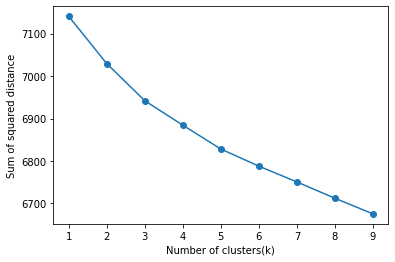

In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_train)
    sse.append(km.inertia_)

plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters(k)')
plt.ylabel('Sum of squared distance');

In [ ]:
kmeanModel = KMeans(n_clusters=8)
kmeanModel.fit(X_train)

KMeans()

In [ ]:
X_train['Cluster'] = kmeanModel.labels_
X_train['Cluster'].sample(n=10)

3911    6
4078    1
5451    0
1407    4
2795    4
7416    5
4620    1
5733    1
6175    0
6016    1
Name: Cluster, dtype: int32

In [ ]:
X_train['Cluster'].value_counts()

1    2391
5    1619
6    1514
4     742
0     618
2     489
7     432
3     403
Name: Cluster, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


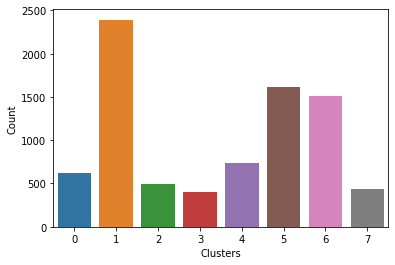

In [ ]:
sns.countplot(X_train['Cluster'])
plt.xlabel('Clusters')
plt.ylabel('Count')
plt.show()

In [ ]:
kmeanModel.cluster_centers_

array([[0.00378379, 0.00489797, 0.00300792, ..., 0.00588244, 0.03757158,
        0.0134475 ],
       [0.00381271, 0.00187246, 0.00257355, ..., 0.00188726, 0.01714453,
        0.00362241],
       [0.00604792, 0.00080623, 0.00501101, ..., 0.0039067 , 0.02357283,
        0.00625434],
       ...,
       [0.00579412, 0.00473275, 0.00568903, ..., 0.00566404, 0.02976847,
        0.00882297],
       [0.00236011, 0.00122665, 0.00286928, ..., 0.00244103, 0.01959508,
        0.00625293],
       [0.00293936, 0.00318861, 0.00079504, ..., 0.00045776, 0.02861979,
        0.00560221]])

#**Recommending through Collaborative Filtering System**

Here, we use the user-item relation to train a model to predict top items that a user may like. This model allows us to recommend a large number of products unlike other models that gives us lower coverage.

**User-Item Matrix**

In [ ]:
new_pr=pr
sentiment_matrix = new_pr.pivot_table(values='total_score', index='asin', columns='reviewerID', fill_value=0)
sentiment_matrix

reviewerID,A00625243BI8W1SSZNLMD,A10044ECXDUVKS,A102MU6ZC9H1N6,A109JTUZXO61UY,A109ME7C09HM2M,A10APIDAZISWQF,A10B2J2IRQXBWA,A10E3QH2FQUBLF,A10FM4ILBIMJJ7,A10H2F00ZOT8S2,A10HYGDU2NITYQ,A10KH8EN77ZKWH,A10N243R7A5ZW3,A10NJEIG56RHN5,A10VG94SAKVSC0,A10ZSXTQA264C7,A110ZEDSNASVCO,A118PM0B1PGWDA,A11E4FWMN9BXJD,A11INIL2YFJ137,A120FZ2ESIMA63,A121QRWXZIO6UP,A126XEMCLHPBNZ,A127K5WGHNUUH3,A12ABV9NU02O29,A12DQZKRKTNF5E,A12N7TJQR2RB9W,A12O5B8XNKNBOL,A12P4A1OC41KUO,A12SSZIN555FTL,A12YXGXV4MATDS,A1365RYO0BLEMI,A136IQFGB01KQB,A136M3QYHUVN9A,A13798OPDBLDCO,A13A81NN0NRD1S,A13GMS7FWV3TQ0,A13IKQCJKFAP5S,A13KBLFF4IZF7H,A13NWJUMVNS6YZ,...,AWBZIK5JYWB5J,AWCJ12KBO5VII,AWIG50VOI5VUV,AWKVQQZKTRFAL,AWQQ1QHCECDJ3,AWV58YYFEAUL0,AWYE428W5MRQN,AWYXB9L41T82S,AX11NOUMV8G95,AX69H7INJKE76,AXABTEYS7A4A8,AXG9N4QFS4QYP,AXJ19189TLBLJ,AXMXE3RT660HQ,AXMYGK3WC8BPP,AXP7888CP2222,AXP9CF1UTFRSU,AXTOICJWZBAJ0,AXU9VX024GPSS,AXWB93VKVML6K,AXWEQHTXQWR7Q,AXWI0P2EGDEQT,AXX6BZDD8K4JL,AXXGP6UT41KAS,AXXYMIJBD0J9G,AYJJDQQ4EZ5V3,AYQ46BHSK99YV,AYQCAPXJ81XTN,AYTKUTAP0VA53,AZ0LJNEP2VRD1,AZ9KESC05F6RI,AZAYBFPLEDFL7,AZBUUKQLYKUCL,AZCP5P3BARLS5,AZE83O4F1IJPR,AZJPNK73JF3XP,AZMHABTPXVLG3,AZMIKIG4BB6BZ,AZPDO6FLSMLFP,AZVME8JMPD3F4
asin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1384719342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00004Y2UT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00005ML71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NSX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NTU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00H02C9TG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00HFRXACG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00IZCSW3M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sentiment_matrix.shape

(900, 1429)

In [ ]:
X = sentiment_matrix
X.head(20)

reviewerID,A00625243BI8W1SSZNLMD,A10044ECXDUVKS,A102MU6ZC9H1N6,A109JTUZXO61UY,A109ME7C09HM2M,A10APIDAZISWQF,A10B2J2IRQXBWA,A10E3QH2FQUBLF,A10FM4ILBIMJJ7,A10H2F00ZOT8S2,A10HYGDU2NITYQ,A10KH8EN77ZKWH,A10N243R7A5ZW3,A10NJEIG56RHN5,A10VG94SAKVSC0,A10ZSXTQA264C7,A110ZEDSNASVCO,A118PM0B1PGWDA,A11E4FWMN9BXJD,A11INIL2YFJ137,A120FZ2ESIMA63,A121QRWXZIO6UP,A126XEMCLHPBNZ,A127K5WGHNUUH3,A12ABV9NU02O29,A12DQZKRKTNF5E,A12N7TJQR2RB9W,A12O5B8XNKNBOL,A12P4A1OC41KUO,A12SSZIN555FTL,A12YXGXV4MATDS,A1365RYO0BLEMI,A136IQFGB01KQB,A136M3QYHUVN9A,A13798OPDBLDCO,A13A81NN0NRD1S,A13GMS7FWV3TQ0,A13IKQCJKFAP5S,A13KBLFF4IZF7H,A13NWJUMVNS6YZ,...,AWBZIK5JYWB5J,AWCJ12KBO5VII,AWIG50VOI5VUV,AWKVQQZKTRFAL,AWQQ1QHCECDJ3,AWV58YYFEAUL0,AWYE428W5MRQN,AWYXB9L41T82S,AX11NOUMV8G95,AX69H7INJKE76,AXABTEYS7A4A8,AXG9N4QFS4QYP,AXJ19189TLBLJ,AXMXE3RT660HQ,AXMYGK3WC8BPP,AXP7888CP2222,AXP9CF1UTFRSU,AXTOICJWZBAJ0,AXU9VX024GPSS,AXWB93VKVML6K,AXWEQHTXQWR7Q,AXWI0P2EGDEQT,AXX6BZDD8K4JL,AXXGP6UT41KAS,AXXYMIJBD0J9G,AYJJDQQ4EZ5V3,AYQ46BHSK99YV,AYQCAPXJ81XTN,AYTKUTAP0VA53,AZ0LJNEP2VRD1,AZ9KESC05F6RI,AZAYBFPLEDFL7,AZBUUKQLYKUCL,AZCP5P3BARLS5,AZE83O4F1IJPR,AZJPNK73JF3XP,AZMHABTPXVLG3,AZMIKIG4BB6BZ,AZPDO6FLSMLFP,AZVME8JMPD3F4
asin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1384719342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00004Y2UT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00005ML71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NSX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NTU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NVI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NW5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NZC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B000068NZG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(900, 1429)

**Correlation Matrix**

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape
'''
The singular value decomposition(SVD) provides another way to factorize a matrix, into singular vectors and singular values. ... The SVD is used widely both in the calculation of other matrix operations, such as matrix inverse, but also as a data reduction method in machine learning
'''
decomposed_matrix.shape

(900, 10)

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix) 
correlation_matrix

array([[ 1.        ,  0.49999349,  0.12658431, ..., -0.24197637,
        -0.20118765, -0.11541915],
       [ 0.49999349,  1.        ,  0.10300534, ...,  0.38263908,
         0.39466227,  0.43726573],
       [ 0.12658431,  0.10300534,  1.        , ...,  0.31010317,
         0.30838326,  0.23823872],
       ...,
       [-0.24197637,  0.38263908,  0.31010317, ...,  1.        ,
         0.99770636,  0.96973931],
       [-0.20118765,  0.39466227,  0.30838326, ...,  0.99770636,
         1.        ,  0.98015532],
       [-0.11541915,  0.43726573,  0.23823872, ...,  0.96973931,
         0.98015532,  1.        ]])

In [ ]:
i = "B00004Y2UT"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

1

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(900,)

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])
# Removes the item already bought by the customer
Recommend.remove(i)
Recommend[0:24]

['B0000AQRST',
 'B0002CZV78',
 'B0002CZVA0',
 'B0002CZVK0',
 'B0002CZZW4',
 'B0002D05FU',
 'B0002D0CA8',
 'B0002D0CIK',
 'B0002D0CL2',
 'B0002D0CLM',
 'B0002D0HY4',
 'B0002E1O7M',
 'B0002E37G8',
 'B0002E37MM',
 'B0002E382Q',
 'B0002E38B2',
 'B0002E3B78',
 'B0002E3MRW',
 'B0002E5518',
 'B0002F7IN0',
 'B0002GJILE',
 'B0002GMGYA',
 'B0002GX5NG',
 'B0002GXV2Q']